# Week 7 Assignment

## Summary:

For the task of conducting sentiment analysis on a customer satisfaction for a product or service, I chose to analyze data gathered from Twitter for the cell phone companies Verizon, AT&T, and T-Mobile. This dataset has over 7,000 tweets collected. On Twitter, each company has a user account for customer support - @VZWSupport (Verizon), @ATTCares (AT&T), and @TMobileHelp (T-Mobile), so I decided that tweets addressed to these accounts would be best to find information related to customer satisfaction.

In the Natural Language Toolkit library (NLTK), I used the VADER (Valence Aware Dictionary and sEntiment Reasoner) module to produce polarity scores (sentiment value) that range from -1.0 to 1.0, that represents a scale of most negative to most positive sentiment and values close to zero being neutral. VADER also generates a ratio to express the distribution of for positive, negative, and neutral words in a text. Using this information I explored overall customer feeling for each provider and discovered trends in what users tend to tweet about each provider.

In [1]:
import numpy as np
import pandas as pd
import string
import spacy

#Scikit-Learn functions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Natural Language Toolkit functions
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

en_stopwords = stopwords.words('english')  
stopwords = set(en_stopwords)  #stopwords has split contractions in it
nlp = spacy.load("en")

%matplotlib inline

C:\Users\Nisha\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
#load in dataset as dataframe
tweets_df = pd.read_csv("cellprovider_tweets.csv", header=None)

In [3]:
#make list of column names
column_names = ['ID', 'language', 'timestamp', 'user', 'likes', 'provider', 'tweet', 'hashtags']

In [4]:
#add column header names to dataframe
tweets_df.columns = column_names

In [5]:
#verify first 5 rows of dataframe
tweets_df.head()

,ID,language,timestamp,user,likes,provider,tweet,hashtags
0,1125995874142654464,en,2019-05-08 05:28:31,Chris E. Hayner,0,Verizon,"@VZWSupport I know my account and services, th...",[]
1,1125994083187548160,en,2019-05-08 05:21:24,Chris E. Hayner,0,Verizon,I’ve had @VZWSupport since 2001 and I’m intere...,[]
2,1125983204912107520,en,2019-05-08 04:38:10,Carlo Gambino,0,Verizon,@VZWSupport @shelby_j0rdan You wouldn't do any...,[]
3,1125970733769875456,en,2019-05-08 03:48:37,Proud New Yorker,0,Verizon,@VZWSupport \r\nMy data is going off every few...,[]
4,1125970705919684608,en,2019-05-08 03:48:30,NKA,0,Verizon,"@VZWSupport My service is not good, I usually ...",[]


### Data Processing

To clean the dataset and filter it down to relevant information for analysis, I used the cleanCorpus function modified to handle social media formatted data (user handles with @ sign, URLs, and retweets). Then I selected tweets that were in English and were not tweeted by the cell phone service provider themselves (their content is usually positive/neutral and would skew results). The hashtags returned by the Twitter API were put into a list so any `hashtag` column values that had empty lists (no hashtags) were replaced as a null value. Finally, I generated the polarity scores and positive, negative, and neutral ratios and assigned each tweet to a sentiment category - if the value was between -0.2 and 0.2, then the tweet was classified as neutral; values above 0.2 would be positive and values below -0.2 were labeled negative.

In [6]:
"""
This function will return a each document (tweet) as a string after making the text lowercase, removing aspotrophes, 
converting into a spaCy object (tokenizing), lemmatizing the words, removing stopwords and Twitter-related extras, rejoining as a string,
then removing all remaining punctuation, numbers, and double white spaces.
"""

#function to lowercase, remove punctuation/digits, tokenize (split into words), and remove stopwords
def cleanCorpus(corpus):
    
    """
    stopwords (list) has split contractions in it
    """
    #apostrophes to look for
    #so words like "people's" don't become "people" and "'s"
    table = str.maketrans({key: None for key in "'" + "‘" + "’"})

    #string w/o apostrophe                    
    no_apos_str = corpus.translate(table).lower()

    #make tweet into a spaCy object
    nlpdoc = nlp(no_apos_str)

    #holds words that are lemmatized, with tweet stuff (RTs, URLs, and @user) removed
    clean_lemmals = []


    for token in nlpdoc:

        #check to see if lemma is "-PRON-"
        #needs to stay in normal text form to get checked as a stopword
        if token.lemma_ == '-PRON-':
            token_lem = token.text
        else:
        #lemmatize the word
            token_lem = token.lemma_

        #check for stopwords, retweets ("RT"), URLs, or users (@username)
        if (token_lem in stopwords) or (token_lem == "rt") or (token_lem.startswith(("http",'@'))): pass

        else: clean_lemmals.append(token_lem)


    #join list of cleaned words together into one string
    clean_str = " ".join(clean_lemmals)  

    #remove rest of punctuation and digits
    #didn't do earlier b/c I didn't want @ removed
    table = str.maketrans({key: None for key in string.punctuation + string.digits + "¦"})
    nopunct_digits = clean_str.translate(table)
    rmv_ws = nopunct_digits.replace("  ", " ")
    
    
    #returned output is a string item from corpus
    return rmv_ws

In [7]:
#use the cleanCorpus function on the dataframe
#assign output to a new column called "cleantweets"
tweets_df['cleantweets'] = tweets_df['tweet'].apply(cleanCorpus)

In [8]:
#verify first 5 rows of dataframe w/ new column
tweets_df.head()

,ID,language,timestamp,user,likes,provider,tweet,hashtags,cleantweets
0,1125995874142654464,en,2019-05-08 05:28:31,Chris E. Hayner,0,Verizon,"@VZWSupport I know my account and services, th...",[],know account service issue coverage apartment ...
1,1125994083187548160,en,2019-05-08 05:21:24,Chris E. Hayner,0,Verizon,I’ve had @VZWSupport since 2001 and I’m intere...,[],since interested try something new la valley f...
2,1125983204912107520,en,2019-05-08 04:38:10,Carlo Gambino,0,Verizon,@VZWSupport @shelby_j0rdan You wouldn't do any...,[],would anything stop front
3,1125970733769875456,en,2019-05-08 03:48:37,Proud New Yorker,0,Verizon,@VZWSupport \r\nMy data is going off every few...,[],\r\n datum go every minute get work properly
4,1125970705919684608,en,2019-05-08 03:48:30,NKA,0,Verizon,"@VZWSupport My service is not good, I usually ...",[],service good usually get service time day slow...


In [9]:
#find languages of all tweets
tweets_df['language'].unique()

array(['en', 'de', 'und', 'it', 'vi', 'nl', 'tr', 'pt', 'fr', 'hi', 'es',
       'tl', 'ht', 'sv', 'in', 'no', 'pl'], dtype=object)

In [10]:
#make new dataframe w/ only English language texts
en_tweet_df = tweets_df.loc[(tweets_df['language'] == "en")]

In [11]:
#get rows where the user is not the cell phone provider company
en_tweet_df = en_tweet_df[en_tweet_df['user'].str.contains("Verizon|ATTCares|AT&T|T-Mobile") == False]

In [12]:
#get rid of the 'tweet' and language columns
cleandf = en_tweet_df.drop(['tweet', 'language'], axis=1)

In [13]:
#if there are no hashtags for a tweet (denoted by empty square brackets), then set value to Null
cleandf.loc[cleandf['hashtags'] == "[]", 'hashtags'] = None

In [14]:
#set Vader sentiment function to a variable
sid = SentimentIntensityAnalyzer()

In [15]:
#function that will get the Vader sentiment scores for a tweet
#returns the compound score (sentiment/polarity value), postitive ratio and negative ratio of words in tweet
def getSentiment(tweet):
    
    sid_scores = sid.polarity_scores(tweet)
    
    sentiment = sid_scores['compound']
    positive = sid_scores['pos']
    negative = sid_scores['neg']
    
    return sentiment, positive, negative

In [16]:
#assign values returned by polarity score function to new columns in dataframe
cleandf['sentiment'] = cleandf['cleantweets'].apply(lambda x: sid.polarity_scores(x)['compound'])
cleandf['positive_ratio'] = cleandf['cleantweets'].apply(lambda x: sid.polarity_scores(x)['pos'])
cleandf['negative_ratio'] = cleandf['cleantweets'].apply(lambda x: sid.polarity_scores(x)['neg'])

In [17]:
#create a function to assign a polarity category to the sentiment
#between -0.2 and 0.2 will be the range for neutrality
def sentimentCategory(sent_num):
    if sent_num >= 0.2:
        return "positive"
    if sent_num <= -0.2:
        return "negative"
    else:
        return "neutral"

In [18]:
#create a new column to hold sentiment category
cleandf['sentiment_category'] = cleandf['sentiment'].apply(sentimentCategory)

In [19]:
#verify the first 5 rows of the dataframe w/ new columns
cleandf.head()

,ID,timestamp,user,likes,provider,hashtags,cleantweets,sentiment,positive_ratio,negative_ratio,sentiment_category
0,1125995874142654464,2019-05-08 05:28:31,Chris E. Hayner,0,Verizon,None,know account service issue coverage apartment ...,-0.5423,0.000,0.189,negative
1,1125994083187548160,2019-05-08 05:21:24,Chris E. Hayner,0,Verizon,None,since interested try something new la valley f...,0.6808,0.318,0.000,positive
2,1125983204912107520,2019-05-08 04:38:10,Carlo Gambino,0,Verizon,None,would anything stop front,-0.2960,0.000,0.423,negative
3,1125970733769875456,2019-05-08 03:48:37,Proud New Yorker,0,Verizon,None,\r\n datum go every minute get work properly,0.0000,0.000,0.000,neutral
4,1125970705919684608,2019-05-08 03:48:30,NKA,0,Verizon,None,service good usually get service time day slow...,0.4404,0.182,0.000,positive


### Explore Data

In this section, much of the data was explored with descriptive statistics and using data visualization. Verizon had 1,000 fewer tweets than AT&T (highest count) but it was still comparable in total number of data points, so the interpretation of the results are still fair. The sentiment scores for each provider are shown as a violin plot with each provider's sentiment score distribution. Then I compared the positive and negative tweets by count and by positive and negative ratio distribution. I also examined the contents of the tweets by individual words, bigrams, and trigrams, which showed trends for typical tweets to each provider and polarity category.

In [20]:
#sum of non-null values for each column
cleandf.count()

ID                    6546
timestamp             6546
user                  6546
likes                 6546
provider              6546
hashtags               545
cleantweets           6546
sentiment             6546
positive_ratio        6546
negative_ratio        6546
sentiment_category    6546
dtype: int64

In [21]:
#number of tweets by provider
cleandf['provider'].value_counts()

AT&T        2885
T-Mobile    1886
Verizon     1775
Name: provider, dtype: int64

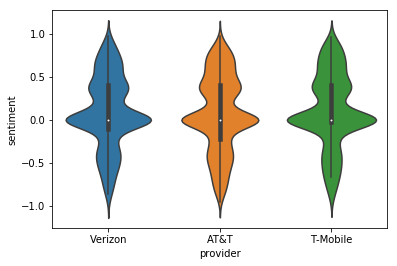

In [22]:
#distribution curve of sentiment by provider
sns.violinplot(data=cleandf, x='provider', y='sentiment')

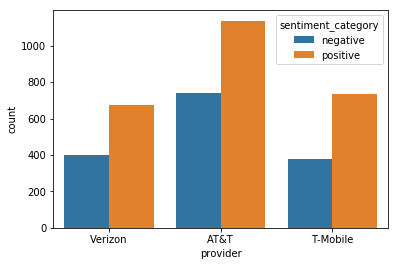

In [23]:
#sum of number of tweets that are positive and negative by provider
sns.countplot(data=cleandf.loc[cleandf['sentiment_category'] != 'neutral'], x='provider', hue='sentiment_category')

In [24]:
#table of average (mean) sentiment score; average positive and negative ratio of tweets
cleandf.pivot_table(index='provider', values=['sentiment', 'positive_ratio', 'negative_ratio'])

,negative_ratio,positive_ratio,sentiment
provider,,,
AT&T,0.119476,0.187157,0.073516
T-Mobile,0.108008,0.196117,0.105811
Verizon,0.109128,0.182767,0.085413


In [25]:
#make dataframes that contain tweets for each provider
vzw_df = cleandf.loc[cleandf['provider'] == "Verizon"]
att_df = cleandf.loc[cleandf['provider'] == "AT&T"]
tmb_df = cleandf.loc[cleandf['provider'] == "T-Mobile"]

In [26]:
#list to hold dataframes
provider_df_ls = [vzw_df, att_df, tmb_df]

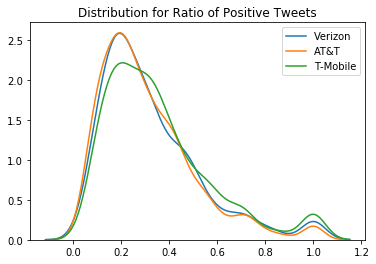

In [27]:
#make a kernal density estimate plot for positive word ratio by tweet for each provider
for providerdf in provider_df_ls:
    
    sns.kdeplot(providerdf['positive_ratio'].loc[providerdf['positive_ratio'] != 0])

plt.title("Distribution for Ratio of Positive Tweets")
plt.legend(labels=['Verizon', 'AT&T', 'T-Mobile'])

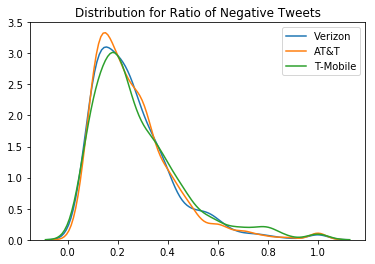

In [28]:
#make a kernal density estimate plot for negative word ratio by tweet for each provider
for providerdf in provider_df_ls:
   
    sns.kdeplot(providerdf['negative_ratio'].loc[providerdf['negative_ratio'] != 0])

plt.title("Distribution for Ratio of Negative Tweets")
plt.legend(labels=['Verizon', 'AT&T', 'T-Mobile'])

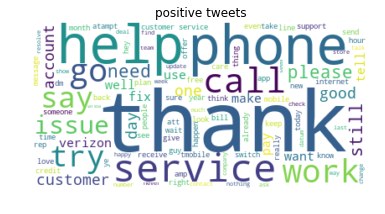

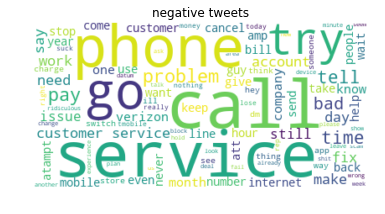

In [29]:
for sentiment in ['positive', 'negative']:
        
        #get tweets that belong to each sentiment category
        sentiment_df = cleandf.loc[cleandf['sentiment_category'] == sentiment]
        
        #make values in "cleantweets" column into a list
        tweet_ls = list(sentiment_df['cleantweets'])
        
        #join list items as one whole string
        tweet_str = " ".join(tweet_ls)
        
        #make a word cloud of all words for all tweets
        wc = WordCloud(max_words=100, background_color="white").generate(tweet_str)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"{sentiment} tweets")
        plt.show()

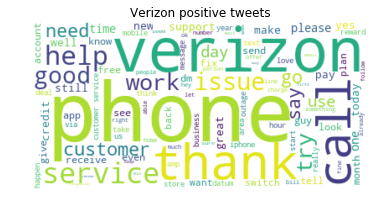

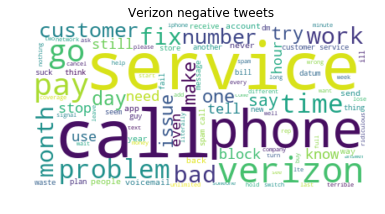

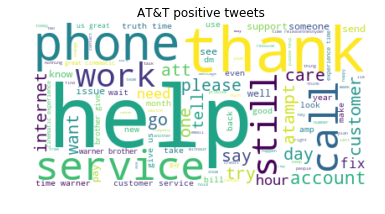

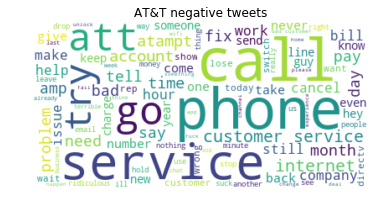

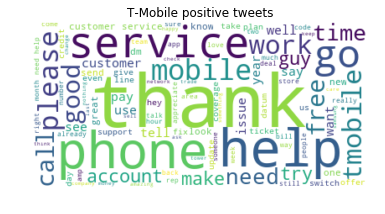

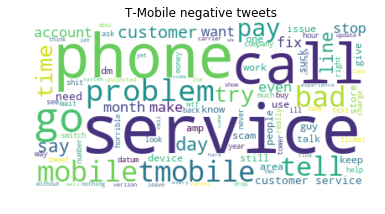

In [30]:
#make word cloud for each sentiment category

for providerdf in provider_df_ls:
    
    #use the unique function to get the name of the provider
    #.unique() should return only one item (b/c providerdf has only tweets of one provider)
    provider_name = providerdf['provider'].unique()[0]
    
    for sentiment in ['positive', 'negative']:
        
        #get rows for each provider for the sentiment category
        sentiment_df = providerdf.loc[providerdf['sentiment_category'] == sentiment]
        
        #turn the values from the 'cleantweets' column into a list
        tweet_ls = list(sentiment_df['cleantweets'])
        
        #put all tweets together as a one string
        col_str = " ".join(tweet_ls)
        
        #make a word cloud of sentiment category by provider
        wc = WordCloud(max_words=100, background_color="white").generate(col_str)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"{provider_name} {sentiment} tweets")
        plt.show()

In [31]:
#generate output of top 10 bigrams by sentiment category

for sentiment in ['positive', 'negative']:
    
    #make a dataframe of rows w/ sentiment category
    sentiment_df = cleandf.loc[cleandf['sentiment_category'] == sentiment]
    
    #turn the values from the 'cleantweets' column into a list
    tweet_ls = list(sentiment_df['cleantweets'])
    
    #empty list to hold all the bigrams
    all_bgs=[]
    
    for tweet in tweet_ls:
        
        #tokenize each tweet
        tweet_tknz = word_tokenize(tweet)
    
        #for each tweet, make bigrams
        for bigram in ngrams(tweet_tknz, 2):
            
            #put bigram words together as one string, separated by a space
            bg_str = " ".join([bigram[0], bigram[1]])
            
            #add bigram string to list
            all_bgs.append(bg_str)
    
    #show output of bigrams for the sentiment category
    print(f"Top 10 bigrams for {sentiment} tweets:")
    for bigram in FreqDist(all_bgs).most_common(10):
        print(bigram[0])
    print("\n") #newline to separate from next sentiment category

Top 10 bigrams for positive tweets:
customer service
give us
please help
need help
truth time
time warner
warner brother
brother give
us great
great cinematic


Top 10 bigrams for negative tweets:
customer service
bad customer
cancel service
spam call
pay bill
call back
🤣 🤣
phone call
drop call
fix problem




In [32]:
#generate output of top 10 trigrams by sentiment category

for sentiment in ['positive', 'negative']:
    
    #make a dataframe of rows w/ sentiment category
    sentiment_df = cleandf.loc[cleandf['sentiment_category'] == sentiment]
    
    #turn the values from the 'cleantweets' column into a list
    tweet_ls = list(sentiment_df['cleantweets'])
    
    #empty list to hold all the trigrams
    all_tgs=[]
        
    for tweet in tweet_ls:
        
        #tokenize each tweet
        tweet_tknz = word_tokenize(tweet)
    
        #for each tweet, make trigrams
        for trigram in ngrams(tweet_tknz, 3):
            
            #put trigram words together as one string, separated by a space
            tg_str = " ".join([trigram[0], trigram[1], trigram[2]])
            
            #add trigram string to list
            all_tgs.append(tg_str)
    
    #show output of trigrams for the sentiment category
    print(f"Top 10 bigrams for {sentiment} tweets")
    for trigram in FreqDist(all_tgs).most_common(10):
        print(trigram[0])
        
    print("\n") #newline to separate from next sentiment category

C:\Users\Nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: generator 'ngrams' raised StopIteration


Top 10 bigrams for positive tweets
truth time warner
time warner brother
warner brother give
brother give us
give us great
us great cinematic
great cinematic experience
cinematic experience time
experience time 👊
time 👊 releasethesnyder


Top 10 bigrams for negative tweets
bad customer service
wife disrespect phone
disrespect phone point
phone point tear
point tear one
tear one csrs
one csrs mel
csrs mel …
🤣 🤣 🤣
horrible customer service




In [33]:
#generate trigrams for sentiment categories by provider

for providerdf in provider_df_ls:
    
    #use the unique function to get the name of the provider
    #.unique() should return only one item (b/c providerdf has only tweets of one provider)
    provider_name = providerdf['provider'].unique()[0]
    
    for sentiment in ['positive', 'negative']:
        
        #make a dataframe of rows w/ sentiment category
        sentiment_df = providerdf.loc[providerdf['sentiment_category'] == sentiment]
        
        #turn the values from the 'cleantweets' column into a list
        tweet_ls = list(sentiment_df['cleantweets'])
        
        #empty list to hold all the trigrams
        all_tgs=[]

        for tweet in tweet_ls:
            
            #tokenize each tweet
            tweet_tknz = word_tokenize(tweet)

            #for each tweet, make trigrams
            for trigram in ngrams(tweet_tknz, 3):
                
                #put trigram words together as one string, separated by a space
                tg_str = " ".join([trigram[0], trigram[1], trigram[2]])
                
                #add trigram string to list
                all_tgs.append(tg_str)

        #show output of trigrams for the sentiment category by provider
        print(f"Top 10 trigrams for {sentiment} tweets for {provider_name}:")
        for trigram in FreqDist(all_tgs).most_common(10):
            print(trigram[0])
            
        print("\n") #newline to separate from next sentiment and provider

C:\Users\Nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: generator 'ngrams' raised StopIteration


Top 10 trigrams for positive tweets for Verizon:
🏻‍ ♀ ️
free version call
version call filter
👏 👏 👏
spend hour phone
ready reward really
reward really really
really really want
really want enroll
want enroll verizon


Top 10 trigrams for negative tweets for Verizon:
🤣 🤣 🤣
absolute worst fake
worst fake empathy
fake empathy every
empathy every single
every single interaction
single interaction “
interaction “ understand
“ understand frustration
understand frustration 🖕


Top 10 trigrams for positive tweets for AT&T:
truth time warner
time warner brother
warner brother give
brother give us
give us great
us great cinematic
great cinematic experience
cinematic experience time
experience time 👊
time 👊 releasethesnyder


Top 10 trigrams for negative tweets for AT&T:
bad customer service
wife disrespect phone
disrespect phone point
phone point tear
point tear one
tear one csrs
one csrs mel
csrs mel …
horrible customer service
customer service ever


Top 10 trigrams for positive tweets for T-M

### K-Means Clustering

I transformed the tweet text into a term frequency - inverse document frequency matrix in order to use the K-Means function from the Scikit-Learn library to build a model that examined all the tweets and classified them into 5 groups.

In [34]:
#make a dataframe of just tweet text data
X = cleandf['cleantweets']

In [35]:
#set TF-IDF vectorizer function to a variable
tfidf_vec = TfidfVectorizer()

In [36]:
#transform the tweets into a TF-IDF matrix (unsupervised learning)
X_mtx = tfidf_vec.fit_transform(X)

In [37]:
#save the KMeans algorithm into a variable
#initialized with 5 clusters and randomize the data
kmeans5 = KMeans(n_clusters=5, random_state=90)

In [38]:
#build the model with the data
kmeans5.fit(X_mtx)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=90, tol=0.0001, verbose=0)

In [39]:
#predict which clusters the tweets belong to
cluster_pred = kmeans5.predict(X_mtx)

In [40]:
#verify first 5 data points' cluster assignments
cluster_pred[:5]

array([2, 2, 4, 2, 2])

In [41]:
#get the silhouette score for the model    
sil_avg = silhouette_score(X_mtx, cluster_pred)

print(f"For 5 clusters, the average silhouette score is: {sil_avg}")

For 5 clusters, the average silhouette score is: 0.020161823556234706


In [42]:
#print the top 10 words for each cluster from the KMeans model (5 clusters)

k5cluster_labels = list(set(cluster_pred))

for cluster_label in k5cluster_labels:
    
    #get the rows from the tweets (assigned as a dataframe called "X", for each cluster group assigned)
    #make the row values into an array (list type)
    cluster_tweets = np.array(X)[cluster_pred == cluster_label]
    
    #tokenize the tweets in the array, then make into one string
    #get frequency distribution and then top 10 words
    top10 = FreqDist(word_tokenize(' '.join(cluster_tweets))).most_common(10)
    
    print(f"The Top 10 words in Cluster {cluster_label}:")
    
    #show output of each top 10 word belong to the cluster group
    for word in top10:
        print(word[0])
        
    print("\n")

The Top 10 words in Cluster 0:
dm
send
thank
please
message
response
follow
info
service
u


The Top 10 words in Cluster 1:
thank
help
response
work
much
service
customer
send
get
issue


The Top 10 words in Cluster 2:
get
phone
call
service
try
customer
help
go
number
back


The Top 10 words in Cluster 3:
john
see
cardi
b
say
mobile
👀
🔥


The Top 10 words in Cluster 4:
service
customer
time
go
help
work
need
…
issue
would




## Conclusion:

In the analysis of the tweets to the Verizon, AT&T, and T-Mobile customer support Twitter accounts, the greatest distribution of sentiment polarity was neutral. Though, when comparing the ends of the sentiment distributions representing negative and positive polarity, the positive end of the curve seemed to have a larger population than the negative end. This means that customers were tweeting more about positive experiences with customer support rather than negatively, and this observation is also shown in the bar chart of total tweets per provider. And among the cell phone service companies, T-Mobile had the highest average sentiment score. 

When evaluating customer satisfication by individual words, users usually thanked the company in positive tweets but for negative tweets, there was no prominent word that expressed a general dissatisfaction. However bigrams were more useful to find trends within negative tweets containing pairings such as "cancel service", "spam call", "pay bill", and "fix problem". But trigrams were best at finding a general dissatisfaction phrase - "bad customer service"/"horrible customer service". For all the customer service providers, trigrams seemed to have very definitive terms for each provider to describe customer dissatifaction - "worst fake empathy" (Verizon), and "bad customer service (AT&T and T-Mobile). 

For the K-Means clustering model when set to establish five clusters, it did not result in many specific terms for each cluster. But one exception were the words/emojis in Cluster 3 such as "john", "cardi", "b", "mobile", 👀, and 🔥. I knew that "cardi" and "b" most likely referred to the musical artist "Cardi B", who is featured in T-Mobile ("mobile"?) advertisements. After searching on Google the additional term "john" along with "Cardi B", I found an article discussing her recent scandal which revealed her past of stealing money from "Johns" (men soliciting for sex). I suspect that the emojis 👀 and 🔥 are in reaction to people's skepticism of the situation and that it's currently a hot topic. Despite the fact that these terms have no relevance to the customer support experience, I wonder if users were tweeting to T-Mobile customer service to remove their advertisements featureing Cardi B. More analysis would need to be conducted in order to answer that question but the insights gained thus far were certainly interesting.

### References:

cjhutto. (2018, December 19). Cjhutto/vaderSentiment. Retrieved from https://github.com/cjhutto/vaderSentiment

illseed. (2019, March 24). Cardi B Used To Jack "Johns" By Drugging Them, Then Robbing Them. Retrieved from https://allhiphop.com/rumors/cardi-b-used-to-jack-johns-by-drugging-them-then-robbing-them-Hxn3lipRfUOz27-1c5T6BQ/